In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import os
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from PIL import Image
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split
import numpy.matlib

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
annotations_list.head()

,img_name,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,rotation_y
0,004863,Car,0.0,0,-1.55,572.44,181.56,611.95,219.71,1.66,1.73,3.05,-0.82,2.08,33.40,-1.57
1,004863,Tram,0.0,0,-1.48,498.85,149.49,551.40,204.32,3.62,2.60,15.21,-6.27,2.16,55.58,-1.60
2,004863,Car,0.0,1,2.12,56.46,195.89,220.78,260.91,1.47,1.71,4.36,-12.68,2.15,19.71,1.55
3,004863,Car,0.0,0,1.92,321.08,188.65,383.52,221.93,1.52,1.71,3.89,-12.88,2.34,36.20,1.58
4,004863,DontCare,-1.0,-1,-10.00,280.40,183.35,291.90,212.56,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00


In [3]:
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)
print("train_list has", len(train_list), "images.")
print("val_list has", len(val_list), "images.")

train_list has 7106 images.
val_list has 375 images.


# 学習データの作成

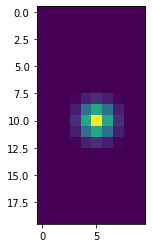

In [4]:
def get_heatmap(h, w, h_center, w_center, sigma=2):
    w_range = np.arange(0,w)-w_center
    w_range = np.matlib.repmat(w_range, h, 1)
    h_range = np.arange(0,h)-h_center
    h_range = h_range.reshape(h,1)
    h_range = np.matlib.repmat(h_range, 1, w)
    Yxyc = np.exp(-(w_range**2+h_range**2)/sigma)
    return Yxyc.T

hm = get_heatmap(10, 20, 5, 10)
plt.imshow(hm)

In [5]:
def line2P(l):
    P_elem = l.split()[1:]
    P = np.array(P_elem, dtype=np.float).reshape(3,-1)
    return P

def readCalib(calib_name, calib_path):
    calib_name = calib_path + calib_name + ".txt"
    with open(calib_name) as f:
        P0 = line2P(f.readline())
        P1 = line2P(f.readline())
        P2 = line2P(f.readline())
        P3 = line2P(f.readline())
        R0_rect = line2P(f.readline())
        Tr_velo_to_cam = line2P(f.readline())
        Tr_imu_to_velo = line2P(f.readline())
    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo

def projectToImage(pts3D, P):
    P = np.array(P)
    
    ones = np.ones([1,pts3D.shape[1]])
    pts3D = np.append(pts3D, ones, axis=0)
    pts2D = np.dot(P, pts3D)
    pts2D[0] /= pts2D[2]
    pts2D[1] /= pts2D[2]
    pts2D = np.delete(pts2D, obj=2, axis=0)
    return pts2D

def selectVisibleSurface(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # right
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # left
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    surface_coord3D = np.zeros([3,4])
    visible_flag = np.zeros(4)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        surface_coord3D[:,i] = c_plane
        if np.dot(c_to_O, normal)>0:
            visible_flag[i] = 1
    return visible_flag==1, surface_coord3D

def selectVisiblePoint(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # right
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # left
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    visible_mask = np.zeros(8)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        if np.dot(c_to_O, normal)>0:
            visible_mask += face_mask[i]
    return visible_mask!=0

def compute3Dbb(obj, P):
    # 直方体の各頂点のxyz座標を計算
    face_idx = np.array([[0,1,5,4], # front face
                         [1,2,6,5], # right face
                         [2,3,7,6], # back face
                         [3,0,4,7]]) # left face
    ry = obj["rotation_y"]
    R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                  [          0, 1,          0],
                  [-np.sin(ry), 0, np.cos(ry)]],
                 dtype=np.float)
    l = obj["length"]
    w = obj["width"]
    h = obj["height"]
    corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                        [0,0,0,0,-h,-h,-h,-h],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                       dtype=np.float).reshape(3,-1)
    corner3D = np.dot(R,corners)
    xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
    corner3D += xyz
    
    # 直方体の各頂点が見えているかどうかを判定
    visible_corner_flag = selectVisiblePoint(corner3D) # 見える頂点を判定
    corner_coord2D = projectToImage(corner3D, P) # 画像座標に変換
    
    # 直方体の面の座標、面が見えているかどうかを判定
    visible_surface_flag, surface_coord3D = selectVisibleSurface(corner3D)
    surface_coord2D = projectToImage(surface_coord3D, P)
    
    if xyz[2]<0.1:
        return []
    else:
        return visible_corner_flag, corner_coord2D, visible_surface_flag, surface_coord2D

def getP2(img_name):
    calib_path = "../data/training/calib/"
    _, _, P2, _, _, _, _ = readCalib(img_name, calib_path)
    return P2

In [6]:
RESIZE_SCALE = 4
IMG_WIDTH = 1280 // RESIZE_SCALE
IMG_HEIGHT = IMG_WIDTH // 16 * 5 #400
MODEL_SCALE = 4

def preprocess_image(img, training=False):
    #画像サイズを統一
    img_shape = img.shape[0]//RESIZE_SCALE, img.shape[1]//RESIZE_SCALE
    if training:
        off_x = randint(0, IMG_WIDTH-img_shape[1])
        off_y = randint(0, IMG_HEIGHT-img_shape[0])
    else:
        off_x = np.round((IMG_WIDTH-img_shape[1])/2).astype('int')
        off_y = np.round((IMG_HEIGHT-img_shape[0])/2).astype('int')
    
    img_dummy = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3])
    resize_img = cv2.resize(img, (img_shape[1], img_shape[0]))
    img_dummy[off_y:off_y+img_shape[0], off_x:off_x+img_shape[1]] = resize_img
    return (img_dummy / 255).astype('float32'), (off_x, off_y)

def get_mask_and_regr(img_name, annotations_list, offset=(0,0)):
    
    ## mask data
    # idx 0 : vehicle
    # idx 1 : front and rear side
    # idx 2 : right and left side
    # idx 3 : 3D corner
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 4], dtype='float32')
    ## size of the vehicle : width, height
    regr_size = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 2], dtype='float32')
    ## offset for 3D detection
    # idx 0,6 : offset from vehicle center to front or rear surface | x, y
    # idx 1,7 : offset from vehicle center to right or left surface | x, y
    # idx 2~5,8~11 : offset from surface(front, rear , right, or left) to each 3D corner
    #                                                               | rb_x, lb_x, lt_x, rt_x, ..., rt_y
    regr_3D = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 12], dtype='float32')
    
    annotations = annotations_list[annotations_list["img_name"]==img_name]

    P2 = getP2(img_name)
    
    target_type = ['Car', 'Van', 'Truck']

    # annotationを遠い順に並び替え
    annos = []
    for _, anno in annotations.iterrows():
        annos.append(anno)
    annos_sorted = sorted(annos, key=lambda x:x['z'], reverse=True)
    
    for anno in annos_sorted:
        if anno["type"] in target_type:
            ## center pointの学習データを作成 
            # annotationをx, y, width, heightに変換
            x = (anno["left"]+anno["right"])/2 / MODEL_SCALE
            y = (anno["top"]+anno["bottom"])/2 / MODEL_SCALE
            width = (anno["right"]-anno["left"]) / MODEL_SCALE
            height = (anno["bottom"]-anno["top"]) / MODEL_SCALE
            
            x = x / RESIZE_SCALE
            y = y / RESIZE_SCALE
            
            x = x+offset[0]/ MODEL_SCALE
            y = y+offset[1]/ MODEL_SCALE
            
            width = width / RESIZE_SCALE
            height = height / RESIZE_SCALE

            ## corner, surfaceの座標を計算
            try: # 前後距離が小さいものは無視
                vsbl_cnr_flg, cnr, vsbl_sfc_flg, sfc = compute3Dbb(anno, P2)
            except:
                continue
            cnr[0] = (cnr[0]/RESIZE_SCALE + offset[0])/MODEL_SCALE
            cnr[1] = (cnr[1]/RESIZE_SCALE + offset[1])/MODEL_SCALE
            sfc[0] = (sfc[0]/RESIZE_SCALE + offset[0])/MODEL_SCALE
            sfc[1] = (sfc[1]/RESIZE_SCALE + offset[1])/MODEL_SCALE
            
            w = max(width,1)
            h = max(height,1)
            left = np.round(max(min(x-w/2,np.min(cnr[0])),0)).astype('int')
            top = np.round(max(min(y-h/2,np.min(cnr[1])),0)).astype('int')
            right = np.round(min(max(x+w/2,np.max(cnr[0])),IMG_WIDTH // MODEL_SCALE)).astype('int')
            bottom = np.round(min(max(y+h/2,np.max(cnr[1])),IMG_HEIGHT // MODEL_SCALE)).astype('int')
            hm = get_heatmap(right-left, bottom-top, w/2, h/2)
            
            # 隠れている車両の正解データを消去(maskのみ)
            pts = cv2.convexHull(np.round(cnr).T.astype(np.int32))
            cv2.fillConvexPoly(mask, points=pts, color=0)

            # x, y, width, heightからmask, regrを作成
            mask[top:bottom, left:right, 0] = hm
            regr_size[top:bottom, left:right, 0] = width
            regr_size[top:bottom, left:right, 1] = height
            
            # cregressionデータの初期化
            nums = np.arange(0,right-left,1)
            nums = np.tile(nums,6).reshape(6,right-left).T
            nums = np.tile(nums,(bottom-top,1)).reshape(bottom-top,right-left,6)
            regr_3D[top:bottom, left:right,:6] = nums
            nums = np.arange(0,bottom-top,1)
            nums = np.tile(nums,6).reshape(6,bottom-top).T
            nums = np.tile(nums,right-left).reshape(bottom-top,right-left,6)
            regr_3D[top:bottom, left:right,6:] = nums
            
            # 
            face_idx = np.array([[0,1,5,4], # front face
                                 [1,2,6,5], # right face
                                 [2,3,7,6], # back face
                                 [3,0,4,7]]) # left face
            ## front, rear
            mask_FaR = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
            for i in range(0,5,2):
                if i < 4 and vsbl_sfc_flg[i]==1:
                    # front, rear中心へのregressionを設定
                    regr_3D[top:bottom, left:right,0] -= (sfc[0,i]-left) # xベクトル
                    regr_3D[top:bottom, left:right,6] -= (sfc[1,i]-top) # yベクトル
                    
                    # front, rear中心から側面の4点へのregressionを設定
                    sfc_cnr = cnr[:,face_idx[i]] # 側面の四角形の座標
                    mask_FaR = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
                    cv2.fillConvexPoly(mask_FaR, points=np.round(sfc_cnr).T.astype(np.int32), color=1)
                    # regressionのoffsetを計算
                    for j in range(4):
                        regr_3D[:,:,j+2] -= (sfc_cnr[0,j]-left) * mask_FaR
                        regr_3D[:,:,j+2+6] -= (sfc_cnr[1,j]-top) * mask_FaR
                    break
                elif i==4:
                    # frontもrearも見えていなかったら
                    regr_3D[top:bottom, left:right,0] = 0 # xベクトル
                    regr_3D[top:bottom, left:right,6] = 0 # yベクトル
            # right, left
            for i in range(1,6,2):
                if i < 5 and vsbl_sfc_flg[i]==1:
                    regr_3D[top:bottom, left:right,1] -= (sfc[0,i]-left) # xベクトル
                    regr_3D[top:bottom, left:right,7] -= (sfc[1,i]-top) # yベクトル
                    
                    # right, left中心から側面の4点へのregressionを設定
                    sfc_cnr = cnr[:,face_idx[i]] # 側面の四角形の座標
                    mask_RaL = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
                    cv2.fillConvexPoly(mask_RaL, points=np.round(sfc_cnr).T.astype(np.int32), color=1)
                    mask_RaL = mask_RaL * (1-mask_FaR)
                    # regressionのoffsetを計算
                    for j in range(4):
                        regr_3D[:,:,j+2] -= (sfc_cnr[0,j]-left) * mask_RaL
                        regr_3D[:,:,j+2+6] -= (sfc_cnr[1,j]-top) * mask_RaL
                    break
                elif i==5:
                    # rightもleftも見えていなかったら
                    regr_3D[top:bottom, left:right,1] = 0 # xベクトル
                    regr_3D[top:bottom, left:right,7] = 0 # yベクトル

            # cornerのmaskを作成
            cnr = cnr[:,vsbl_cnr_flg]
            cnr = np.round(cnr).astype('int')
            if w > 3:
                for i in range(cnr.shape[1]):
                    if 0 <= cnr[1,i] and cnr[1,i] < mask.shape[0] and\
                       0 <= cnr[0,i] and cnr[0,i] < mask.shape[1]:
                        # 画像外だったら何もしない
                        mask[cnr[1,i],cnr[0,i],3] = 1
            # surfaceのmaskを作成
            sfc = np.round(sfc).astype('int')
            if w > 3:
                for i in range(4):
                    if 0 <= sfc[1,i] and sfc[1,i] < mask.shape[0] and \
                       0 <= sfc[0,i] and sfc[0,i] < mask.shape[1] and \
                       vsbl_sfc_flg[i]==1:
                        # 画像外だったら何もしない
                        if i%2==0: # 前後面のmaskを設定
                            mask[sfc[1,i],sfc[0,i],1] = 1
                        elif mask_FaR[sfc[1,i],sfc[0,i]]==0: # 左右面のregressionが上書きされていたらmaskを設定しない
                            mask[sfc[1,i],sfc[0,i],2] = 1
    return mask, regr_size, regr_3D

In [7]:
def get_img_path(img_name_list):
    for i in range(len(img_name_list)):
        img_name_list[i] = PATH + "image_2/" + img_name_list[i] + ".png"
        return img_name_list

In [8]:
img_name = train_list[8]
img_name_list = get_img_path([img_name])
img = plt.imread(img_name_list[0])
img, offset = preprocess_image(img)
mask, regr_size, regr_3D = get_mask_and_regr(img_name, annotations_list, offset)

# 学習データ生成のためのclassを定義

In [9]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, annotation, root_dir, training=True):
        self.data_list = data_list
        self.anno = annotation
        self.root_dir = root_dir
        self.training = training
        
        self.anno = pd.read_pickle(ANNOTATIONS)
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data
        img_name = self.data_list[idx]
        img_path = self.root_dir + "image_2/" + img_name + ".png"
        img = plt.imread(img_path)
        img, offset = preprocess_image(img, self.training)
        
        if self.training:
            mask, regr_size, regr_3D = get_mask_and_regr(img_name, self.anno, offset)
            # Augmentation
            fliplr = rand()>.5
            if fliplr:
                img, mask, regr_size, regr_3D = img[:,::-1], mask[:,::-1], regr_size[:,::-1], regr_3D[:,::-1]
                regr_3D[:,:,0:6] *= -1
                regr_3D = regr_3D[:,:,[0,1,3,2,5,4,6,7,9,8,11,10]] # corner regressionを左下から時計回りに修正
            fliptb = rand()>.5
            if fliptb and False:
                img, mask, regr_size, regr_3D = img[::-1], mask[::-1], regr_size[::-1], regr_3D[::-1]
                regr_3D[:,:,6:] *= -1
                regr_3D = regr_3D[:,:,[0,1,5,4,3,2,6,7,11,10,9,8]] # corner regressionを左下から時計回りに修正
            
            # 配列の向き？を入れ替える
            mask = np.rollaxis(mask, 2, 0)
            regr_size = np.rollaxis(regr_size, 2, 0)
            regr_3D = np.rollaxis(regr_3D, 2, 0)
        img = np.rollaxis(img, 2, 0)
            
        if self.training:
            return [img.copy(), mask.copy(), regr_size.copy(), regr_3D.copy()]
        else:
            return img

In [10]:
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=True)

In [11]:
BATCH_SIZE = 16

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# DL Model

In [12]:
from efficientnet_pytorch import EfficientNet

In [13]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [14]:
class EfficientNet_(EfficientNet):
    
    def extract_features_midconv(self, inputs):
        out = []
        
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            y = block(x, drop_connect_rate=drop_connect_rate)
            if y.size()[-1] != x.size()[-1]:
                out.append(x)
            x = y
            
        x = self._swish(self._bn1(self._conv_head(x)))
        out.append(x)
        
        return out[1:]

In [15]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet_.from_pretrained('efficientnet-b0')
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 112, 256)
        self.up2 = up(256 + 40, 128)
        self.up3 = up(128 + 24, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x2, x3, x4, x5 = self.base_model.extract_features_midconv(x)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, x5.shape[2], x5.shape[3])
        x5 = torch.cat([x5, mesh2], 1)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.outc(x)
        return x

In [16]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 50

## MyUNetの出力ベクトル長を設定
model = MyUNet(18).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.1,
                              patience=1,
                              verbose=True
                             )

cpu
Loaded pretrained weights for efficientnet-b0


# Training

In [17]:
lambda_size = 0.01
lambda_3D = 0.1

def criterion(prediction, mask, regr_size, regr_3D):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0:4])
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression size loss
    pred_regr = prediction[:, 4:6]
    size_loss = (torch.abs(pred_regr - regr_size).sum(1) * mask[:,0]).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    size_loss = size_loss.mean(0)
    
    # Regression 3D loss
    pred_regr = prediction[:,[6,7,12,13]]
    regr = regr_3D[:,[0,1,6,7]]
    sfc_loss = (torch.abs(pred_regr - regr).sum(1) * mask[:,0]).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    sfc_loss = sfc_loss.mean(0)
    pred_regr = prediction[:,[8,9,10,11,14,15,16,17]]
    regr = regr_3D[:,[2,3,4,5,8,9,10,11]]
    cnr_loss = (torch.abs(pred_regr - regr).sum(1) * (mask[:,1]+mask[:,2])).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    cnr_loss = cnr_loss.mean(0)
    
    return mask_loss, lambda_size*size_loss, lambda_3D*(sfc_loss+cnr_loss)

In [18]:
FINE_TUNE_EPOCH = 35

def train_model(epoch, history=None):
    model.train()
    train_mask_loss = 0
    train_regr_size_loss = 0
    train_regr_3D_loss = 0
    
    for batch_idx, (img_batch, mask_batch, regr_size_batch, regr_3D_batch) in enumerate(tqdm(train_loader)):
            
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_size_batch = regr_size_batch.to(device)
        regr_3D_batch = regr_3D_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        mask_loss, regr_size_loss, regr_3D_loss =\
            criterion(output, mask_batch, regr_size_batch, regr_3D_batch)
        loss = mask_loss + regr_size_loss + regr_3D_loss
        loss.backward()
        optimizer.step()
            
        train_mask_loss += mask_loss.detach()
        train_regr_size_loss += regr_size_loss.detach()
        train_regr_3D_loss += regr_3D_loss.detach()
    
    train_mask_loss /= len(train_dataset)
    train_regr_size_loss /= len(train_dataset)
    train_regr_3D_loss /= len(train_dataset)
    train_loss = train_mask_loss + train_regr_size_loss + train_regr_3D_loss
    
    if history is not None:
        history.loc[epoch, 'train_mask_loss'] = train_mask_loss.data.cpu().numpy()
        history.loc[epoch, 'train_regr_size_loss'] = train_regr_size_loss.data.cpu().numpy()
        history.loc[epoch, 'train_regr_3D_loss'] = train_regr_3D_loss.data.cpu().numpy()
        history.loc[epoch, 'train_loss'] = train_loss.data.cpu().numpy()
        
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        train_loss))

def evaluate_model(epoch, history=None):
    model.eval()
    val_mask_loss = 0
    val_regr_size_loss = 0
    val_regr_3D_loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_size_batch, regr_3D_batch in val_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_size_batch = regr_size_batch.to(device)
            regr_3D_batch = regr_3D_batch.to(device)

            output = model(img_batch)

            mask_loss, regr_size_loss, regr_3D_loss =\
                criterion(output, mask_batch, regr_size_batch, regr_3D_batch)
                    
            val_mask_loss += mask_loss.detach()
            val_regr_size_loss += regr_size_loss.detach()
            val_regr_3D_loss += regr_3D_loss.detach()
    
    val_mask_loss /= len(val_dataset)
    val_regr_size_loss /= len(val_dataset)
    val_regr_3D_loss /= len(val_dataset)
    val_loss = val_mask_loss + val_regr_size_loss + val_regr_3D_loss
    
    if history is not None:
        history.loc[epoch, 'val_mask_loss'] = val_mask_loss.data.cpu().numpy()
        history.loc[epoch, 'val_regr_size_loss'] = val_regr_size_loss.data.cpu().numpy()
        history.loc[epoch, 'val_regr_3D_loss'] = val_regr_3D_loss.data.cpu().numpy()
        history.loc[epoch, 'val_loss'] = val_loss.data.cpu().numpy()
    
    print('Val loss: {:.4f}'.format(val_loss))
    
    scheduler.step(val_loss)

In [19]:
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    if epoch == 0:
        print("Base model parameters are FREEZED.")
        for param in model.base_model.parameters():
            param.requires_grad = False
    elif epoch == FINE_TUNE_EPOCH:
        print("Base model parameters are UNFREEZED.")
        for param in model.base_model.parameters():
            param.requires_grad = True
            
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)
    torch.save(model.state_dict(), '../models/model_' + str(epoch) + '.pth')

  0%|          | 0/445 [00:00<?, ?it/s]

Base model parameters are FREEZED.


100%|██████████| 445/445 [08:26<00:00,  1.14s/it]


Train Epoch: 0 	LR: 0.100000	Loss: 11.113677
Val loss: 49.2489


100%|██████████| 445/445 [08:20<00:00,  1.12s/it]

Train Epoch: 1 	LR: 0.100000	Loss: 8.682487


Val loss: 8.8727


100%|██████████| 445/445 [08:26<00:00,  1.14s/it]

Train Epoch: 2 	LR: 0.100000	Loss: 8.110178


Val loss: 7.3027


100%|██████████| 445/445 [08:17<00:00,  1.12s/it]

Train Epoch: 3 	LR: 0.100000	Loss: 7.819742


Val loss: 6.9497


100%|██████████| 445/445 [08:42<00:00,  1.17s/it]

Train Epoch: 4 	LR: 0.100000	Loss: 7.537059


Val loss: 6.8642


100%|██████████| 445/445 [08:46<00:00,  1.18s/it]

Train Epoch: 5 	LR: 0.100000	Loss: 7.383341


Val loss: 6.9381


100%|██████████| 445/445 [09:43<00:00,  1.31s/it]

Train Epoch: 6 	LR: 0.100000	Loss: 7.236883


Val loss: 6.5494


100%|██████████| 445/445 [09:39<00:00,  1.30s/it]

Train Epoch: 7 	LR: 0.100000	Loss: 7.105668


Val loss: 6.4724


100%|██████████| 445/445 [09:37<00:00,  1.30s/it]

Train Epoch: 8 	LR: 0.100000	Loss: 6.995458


Val loss: 6.3813


100%|██████████| 445/445 [09:35<00:00,  1.29s/it]

Train Epoch: 9 	LR: 0.100000	Loss: 6.918099


Val loss: 6.2790


100%|██████████| 445/445 [09:21<00:00,  1.26s/it]

Train Epoch: 10 	LR: 0.100000	Loss: 6.819230


Val loss: 6.0957


100%|██████████| 445/445 [09:09<00:00,  1.23s/it]

Train Epoch: 11 	LR: 0.100000	Loss: 6.748757


Val loss: 6.1216


100%|██████████| 445/445 [09:11<00:00,  1.24s/it]

Train Epoch: 12 	LR: 0.100000	Loss: 6.678144


Val loss: 6.0402


100%|██████████| 445/445 [09:16<00:00,  1.25s/it]

Train Epoch: 13 	LR: 0.100000	Loss: 6.613383


Val loss: 5.9973


100%|██████████| 445/445 [10:27<00:00,  1.41s/it]

Train Epoch: 14 	LR: 0.100000	Loss: 6.524183


Val loss: 6.0492


100%|██████████| 445/445 [10:01<00:00,  1.35s/it]

Train Epoch: 15 	LR: 0.100000	Loss: 6.493692


Val loss: 6.0172
Epoch    16: reducing learning rate of group 0 to 1.0000e-02.


100%|██████████| 445/445 [09:27<00:00,  1.28s/it]

Train Epoch: 16 	LR: 0.010000	Loss: 6.132767


Val loss: 5.6537


100%|██████████| 445/445 [09:28<00:00,  1.28s/it]

Train Epoch: 17 	LR: 0.010000	Loss: 6.032299


Val loss: 5.6361


100%|██████████| 445/445 [09:33<00:00,  1.29s/it]

Train Epoch: 18 	LR: 0.010000	Loss: 6.026545


Val loss: 5.6018


100%|██████████| 445/445 [09:29<00:00,  1.28s/it]

Train Epoch: 19 	LR: 0.010000	Loss: 5.980632


Val loss: 5.5651


100%|██████████| 445/445 [09:29<00:00,  1.28s/it]

Train Epoch: 20 	LR: 0.010000	Loss: 5.947254


Val loss: 5.5472


100%|██████████| 445/445 [09:26<00:00,  1.27s/it]

Train Epoch: 21 	LR: 0.010000	Loss: 5.924675


Val loss: 5.5315


100%|██████████| 445/445 [09:24<00:00,  1.27s/it]

Train Epoch: 22 	LR: 0.010000	Loss: 5.896248


Val loss: 5.5024


100%|██████████| 445/445 [09:26<00:00,  1.27s/it]

Train Epoch: 23 	LR: 0.010000	Loss: 5.847919


Val loss: 5.5130


100%|██████████| 445/445 [09:30<00:00,  1.28s/it]

Train Epoch: 24 	LR: 0.010000	Loss: 5.915067


Val loss: 5.4730


100%|██████████| 445/445 [09:29<00:00,  1.28s/it]

Train Epoch: 25 	LR: 0.010000	Loss: 5.816315


Val loss: 5.4917


100%|██████████| 445/445 [09:30<00:00,  1.28s/it]

Train Epoch: 26 	LR: 0.010000	Loss: 5.800001


Val loss: 5.4741
Epoch    27: reducing learning rate of group 0 to 1.0000e-03.


100%|██████████| 445/445 [09:29<00:00,  1.28s/it]

Train Epoch: 27 	LR: 0.001000	Loss: 5.753996


Val loss: 5.4629


100%|██████████| 445/445 [09:31<00:00,  1.28s/it]

Train Epoch: 28 	LR: 0.001000	Loss: 5.756733


Val loss: 5.4507


100%|██████████| 445/445 [09:31<00:00,  1.28s/it]

Train Epoch: 29 	LR: 0.001000	Loss: 5.730113


Val loss: 5.4412


100%|██████████| 445/445 [09:31<00:00,  1.28s/it]

Train Epoch: 30 	LR: 0.001000	Loss: 5.720052


Val loss: 5.4476


100%|██████████| 445/445 [09:30<00:00,  1.28s/it]

Train Epoch: 31 	LR: 0.001000	Loss: 5.742278


Val loss: 5.4382


100%|██████████| 445/445 [09:31<00:00,  1.28s/it]

Train Epoch: 32 	LR: 0.001000	Loss: 5.731576


Val loss: 5.4378


100%|██████████| 445/445 [09:28<00:00,  1.28s/it]

Train Epoch: 33 	LR: 0.001000	Loss: 5.721322


Val loss: 5.4369


100%|██████████| 445/445 [09:28<00:00,  1.28s/it]

Train Epoch: 34 	LR: 0.001000	Loss: 5.738112


Val loss: 5.4365
Base model parameters are UNFREEZED.


100%|██████████| 445/445 [16:49<00:00,  2.27s/it]

Train Epoch: 35 	LR: 0.001000	Loss: 6.130186


Val loss: 5.7689
Epoch    36: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 445/445 [16:50<00:00,  2.27s/it]

Train Epoch: 36 	LR: 0.000100	Loss: 5.820702


Val loss: 5.3859


100%|██████████| 445/445 [16:46<00:00,  2.26s/it]

Train Epoch: 37 	LR: 0.000100	Loss: 5.724500


Val loss: 5.3444


100%|██████████| 445/445 [16:47<00:00,  2.26s/it]

Train Epoch: 38 	LR: 0.000100	Loss: 5.642127


Val loss: 5.2673


100%|██████████| 445/445 [16:49<00:00,  2.27s/it]

Train Epoch: 39 	LR: 0.000100	Loss: 5.588252


Val loss: 5.2502


100%|██████████| 445/445 [16:52<00:00,  2.27s/it]

Train Epoch: 40 	LR: 0.000100	Loss: 5.543706


Val loss: 5.2426


100%|██████████| 445/445 [16:49<00:00,  2.27s/it]

Train Epoch: 41 	LR: 0.000100	Loss: 5.505436


Val loss: 5.2615


100%|██████████| 445/445 [16:49<00:00,  2.27s/it]

Train Epoch: 42 	LR: 0.000100	Loss: 5.485123


Val loss: 5.2412


100%|██████████| 445/445 [16:55<00:00,  2.28s/it]

Train Epoch: 43 	LR: 0.000100	Loss: 5.447570


Val loss: 5.2424


100%|██████████| 445/445 [16:52<00:00,  2.28s/it]

Train Epoch: 44 	LR: 0.000100	Loss: 5.398481


Val loss: 5.1632


100%|██████████| 445/445 [16:51<00:00,  2.27s/it]

Train Epoch: 45 	LR: 0.000100	Loss: 5.409877


Val loss: 5.1413


100%|██████████| 445/445 [16:53<00:00,  2.28s/it]

Train Epoch: 46 	LR: 0.000100	Loss: 5.349324


Val loss: 5.1195


 67%|██████▋   | 299/445 [11:32<05:38,  2.32s/it]

KeyboardInterrupt: 

In [20]:
torch.save(model.state_dict(), '../models/model.pth')
model_cpu = model.to('cpu')
torch.save(model_cpu.state_dict(), '../models/model_cpu.pth')

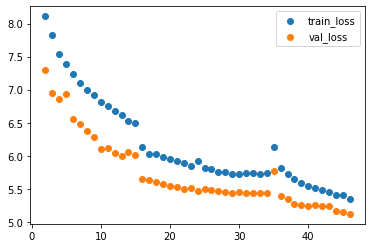

In [21]:
train_loss = history.dropna()['train_loss']
val_loss = history.dropna()['val_loss']
plt.scatter(train_loss.index[2:], train_loss[2:])
plt.scatter(val_loss.index[2:], val_loss[2:])
plt.legend(["train_loss", "val_loss"])

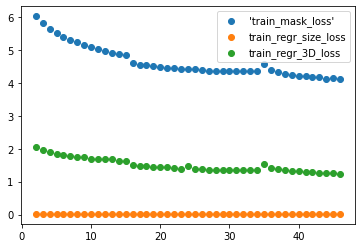

In [22]:
train_mask_loss = history.dropna()['train_mask_loss']
train_regr_size_loss = history.dropna()['train_regr_size_loss']
train_regr_3D_loss = history.dropna()['train_regr_3D_loss']
plt.scatter(train_loss.index[2:], train_mask_loss[2:])
plt.scatter(train_loss.index[2:], train_regr_size_loss[2:])
plt.scatter(train_loss.index[2:], train_regr_3D_loss[2:])
plt.legend(["'train_mask_loss'", "train_regr_size_loss", "train_regr_3D_loss"])

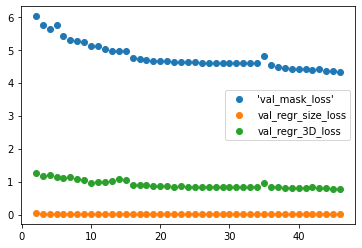

In [23]:
val_mask_loss = history.dropna()['val_mask_loss']
val_regr_size_loss = history.dropna()['val_regr_size_loss']
val_regr_3D_loss = history.dropna()['val_regr_3D_loss']
plt.scatter(val_loss.index[2:], val_mask_loss[2:])
plt.scatter(val_loss.index[2:], val_regr_size_loss[2:])
plt.scatter(val_loss.index[2:], val_regr_3D_loss[2:])
plt.legend(["'val_mask_loss'", "val_regr_size_loss", "val_regr_3D_loss"])

In [ ]:
torch.cuda.empty_cache()
gc.collect()

# Check result

In [ ]:
m = MyUNet(18)
m.eval()
m_state_dict = torch.load("../models/model.pth")
m.load_state_dict(m_state_dict)

In [ ]:
img, mask, regr, cnr, regr_cnr = val_dataset[0]
img2 = np.rollaxis(img, 0, 3)
plt.figure(figsize=(15,8))
plt.imshow(img2*255)

In [ ]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

In [ ]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,3].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

In [ ]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,4].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()